# Chapter 5
> FastBook Chapter 5 Pet Breeds, In this notebook I followed both Jeremy Howard's Lesson on fast.ai and Weigh and Biases reading group videos. Lots of annotations added, some cell's order changed some are added to make the topic more understandable for me. (Check Manual calculation `log_softmax` + `nll_loss`)
click `open in colab` button at the right side to view as notebook.

- toc: true 
- badges: true
- comments: true
- categories: [fastbook]
- image: images/cyberman.png

![](images/chapter-05/cyberman.png)

>  This is my cyberman caffee cup, as I remember got it from Manchester Science Museum.

In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
%config Completer.use_jedi = False

In [2]:
from fastbook import *

[[chapter_pet_breeds]]

## PLAYING WITH THE DATASET

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

> Note: With `untar` we download the data. This data originally come from Oxford University [Visual Geomety Group](https://www.robots.ox.ac.uk/~vgg/data/) and our data set is [here:](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [4]:
path

Path('/home/niyazi/.fastai/data/oxford-iiit-pet')

> Note: __This is local download path for my computer.__

In [5]:
Path.BASE_PATH = path

> Tip: **This is a trick to get relative path, check above and below**

In [6]:
path

Path('.')

__Now the `path` is like above__

In [7]:
path.ls()

(#2) [Path('annotations'),Path('images')]

> Note: __'#2' is number of item in the list. `annotations` represents target variables of this datasets but we do not use them at this time instead we create our own labels.__

In [8]:
(path/"images").ls()

(#7393) [Path('images/staffordshire_bull_terrier_90.jpg'),Path('images/Russian_Blue_70.jpg'),Path('images/japanese_chin_69.jpg'),Path('images/Maine_Coon_266.jpg'),Path('images/japanese_chin_200.jpg'),Path('images/Siamese_57.jpg'),Path('images/Persian_175.jpg'),Path('images/havanese_81.jpg'),Path('images/Birman_72.jpg'),Path('images/leonberger_55.jpg')...]

In [9]:
fname = (path/"images").ls()[0]

In [10]:
fname

Path('images/staffordshire_bull_terrier_90.jpg')

> Note: The first image in the `path` list.

In [11]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['staffordshire_bull_terrier']

> Note: Since we don't use the annonations in the Dataset we need to find a way to get breeds form the filename. This is regex `findall` method, Check regular expression tutorial [here](https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/)

In [12]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


> Note: now find all names with RegexLabeller. the `item_tmsf` and `batch_transfdrms` that looks a bit intereresting,

In [13]:
type(dls)

fastai.data.core.DataLoaders

### PRESIZING

__check the original document for the idea__

As a summary FastAi gives a chance to augment our images in a smarter way such that provide much more detail and information for the taining.

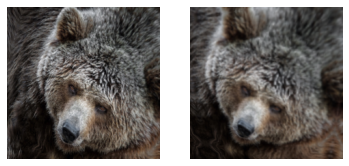

In [14]:
#id interpolations
#caption A comparison of fastai's data augmentation strategy (left) and the traditional approach (right).
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'chapter-05'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

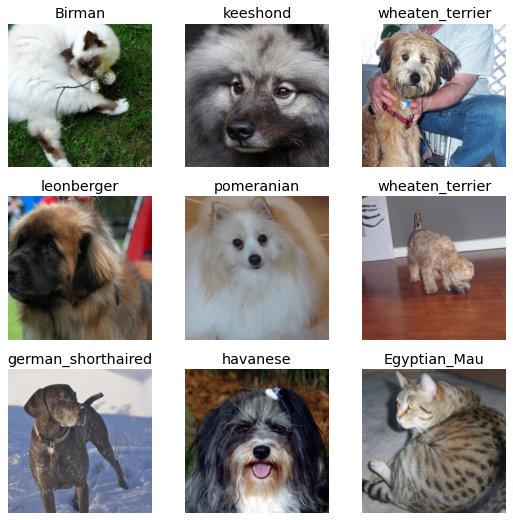

In [15]:
dls.show_batch(nrows=3, ncols=3)

In [19]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/niyazi/.fastai/data/oxford-iiit-pet/images/British_Shorthair_110.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/niyazi/.fastai/data/oxford-iiit-pet/images/British_Shorthair_110.jpg
    applying partial gives
      British_Shorthair
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(4))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'ad

RuntimeError: stack expects each tensor to be equal size, but got [3, 333, 500] at entry 0 and [3, 500, 396] at entry 1

> Note: It is alway good to get a quick summary. Check the summary above. It is natural to get an error in this example because we are trying the put diffent sized images into the same `DataBlock`.

## Baseline model

In [18]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.457605,0.352995,0.105548,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.497642,0.349454,0.112314,00:26
1,0.317850,0.240670,0.079161,00:26


> Note: A basic run is helpful as baseline for the beginning.

### Defaults for the baseline

In [21]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [19]:
learn.lr

0.001

> Tip: Very easy to see default arguments for the learner. Above loss function `loss_func` and learning rate `lr`. 

### One Batch Run

In [20]:
first(dls.train)

(TensorImage([[[[-0.2266,  0.0924,  0.5782,  ..., -0.5764, -0.5718, -0.6178],
           [ 0.0232, -0.3636, -0.1483,  ..., -0.4050, -0.6272, -0.8132],
           [-0.4864, -0.1169,  0.0829,  ..., -0.1269, -0.3616, -0.3792],
           ...,
           [-1.3950, -1.4344, -1.3271,  ..., -0.2968,  0.1796,  0.4601],
           [-1.3216, -1.4117, -1.2814,  ..., -0.1971,  0.2348,  0.3410],
           [-1.1776, -1.1273, -1.1513,  ..., -0.3427, -0.0638,  0.4218]],
 
          [[-0.1022,  0.1950,  0.6573,  ..., -0.5845, -0.5961, -0.6692],
           [ 0.1658, -0.2557, -0.0520,  ..., -0.3826, -0.6528, -0.7897],
           [-0.3518,  0.0344,  0.1975,  ..., -0.0251, -0.3143, -0.3295],
           ...,
           [-1.2658, -1.2947, -1.2050,  ..., -0.4220, -0.0421,  0.2915],
           [-1.1631, -1.2514, -1.1414,  ..., -0.3039,  0.0126,  0.1567],
           [-1.0169, -0.9665, -1.0053,  ..., -0.5230, -0.3099,  0.2061]],
 
          [[-1.1227, -0.6550, -0.0869,  ..., -0.7543, -0.8071, -0.9924],
        

> Note: above and below is same

In [21]:
x,y = dls.one_batch()

### Understanding Labels

In [29]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [31]:
dls.vocab[0]

'Abyssinian'

> Tip: `vocab` gives as all labels as text.

In [45]:
### What's inside the tensors?

In [21]:
y

TensorCategory([25,  4, 27, 20, 12, 27, 31, 33, 14, 35, 16,  5, 22, 33,  3, 35,  3,  0, 32, 12,  1, 20, 18, 22, 15, 11, 13,  5, 35,  4, 22, 34, 15,  4,  3, 21,  5, 22, 27, 11, 15, 13, 14, 32, 13,  4,  7, 30,
         9, 20,  7, 20,  9,  1,  6, 35, 23,  8, 14, 16, 18,  6,  2, 35], device='cuda:0')

> Note: Targets as coded.

In [23]:
x

TensorImage([[[[-1.5782, -1.7255, -1.9275,  ..., -1.6330, -1.6380, -1.5983],
          [-1.8080, -1.7849, -1.8237,  ..., -1.6854, -1.6497, -1.6160],
          [-1.7805, -1.9846, -1.8070,  ..., -1.7872, -1.7422, -1.7448],
          ...,
          [ 0.2610,  0.0782,  0.2825,  ..., -1.0197, -0.7567, -0.5126],
          [ 0.2102,  0.3495,  0.4070,  ..., -0.9104, -0.2978, -0.3182],
          [ 0.1073,  0.2460,  0.3919,  ..., -0.5615, -0.0283, -0.0868]],

         [[-1.4595, -1.5448, -1.7839,  ..., -1.8157, -1.8280, -1.7952],
          [-1.7047, -1.5924, -1.6316,  ..., -1.8512, -1.8226, -1.7953],
          [-1.7188, -1.8761, -1.6515,  ..., -1.9263, -1.8895, -1.9038],
          ...,
          [-0.4721, -0.7089, -0.4992,  ..., -1.3913, -1.0786, -0.9552],
          [-0.5585, -0.4309, -0.3815,  ..., -1.4235, -0.8120, -0.9214],
          [-0.7029, -0.5853, -0.4174,  ..., -1.0932, -0.6124, -0.6962]],

         [[-1.1973, -1.3697, -1.6175,  ..., -1.7907, -1.8010, -1.7709],
          [-1.4681, -1.41

> Note: Our stacked images. 

### Predictions of the baseline model.

In [24]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.9299e-05, 4.9273e-06, 6.5637e-07, 1.3213e-06, 3.0726e-05, 3.5227e-06, 1.9753e-05, 4.7022e-06, 1.8091e-05, 2.5976e-05, 3.0315e-06, 2.2854e-04, 5.6780e-03, 9.8708e-01, 2.5719e-05, 2.6411e-03,
        2.5113e-03, 2.7535e-04, 3.5884e-06, 1.9030e-06, 4.6491e-05, 3.8401e-07, 1.6292e-06, 3.3919e-06, 6.9697e-06, 1.3987e-06, 5.8959e-05, 3.0408e-06, 2.8120e-05, 2.3738e-06, 2.7004e-05, 5.0658e-05,
        3.1840e-06, 4.2689e-05, 1.1184e-03, 1.7468e-05, 1.4993e-05])

> Note: __result for fist item that adds up to one. There are 37 outputs for 37 image categories and the results are in percentage for probability of each category.__

In [46]:
_

TensorCategory([13, 35,  8, 36,  3, 10, 10, 14, 22,  1,  5,  5,  5,  0,  4,  7, 11, 33, 18, 25, 20,  3, 33,  0, 25, 15, 27,  9, 17, 25, 19, 26,  9,  0, 35,  5,  6,  1, 31, 14,  7,  9,  8, 27,  2,  7, 21, 13,
        26, 17, 25, 30, 31,  5, 19, 17,  4, 12, 29,  8, 21, 33, 18,  9])

__category codes__

In [47]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

37 categories that adds up to one.

## Function for classifiying more than one category.

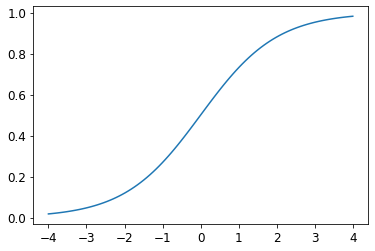

In [48]:
plot_function(torch.sigmoid, min=-4,max=4)

__This is how `torch.sigmoid` squish values between 0 and 1.__

In [49]:
torch.random.manual_seed(42);

In [50]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

> Note: These are random numbers that represent binary results of a network. First colums represent 3's the and second is 7's standart deviation of 2. It generally shows how confident the model about the predictions.

In [51]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

> Note: If we apply the sigmoid the result become like this(above). Obviously they are not adds up to one. These are relative confidence over inputs.

In [52]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

> Note: If we take the difference between these relative confidence the results become this above:

__this part is a bit different in the lesson video. so check the video. 1:35:20__

In [53]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

> Note: `torch.softmax` does that in one step. Now results for each item adds up to one,

### __Log Likelihood__

In [54]:
targ = tensor([0,1,0,1,1,0])

In [55]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

__this is our softmax activations__

In [57]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

__These are again confidence level our model on each item__

In [61]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


> Note: results as a table.

> Warning: I think label is wrong here. It must be the confidence instead.

In [62]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

> Warning: This is a caveat here. These are neg of our confidence level, not loss. 

In [63]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

> Warning: Pytorch way of doing the same here above. In one step. But number are still not right, that will be addresses in the `Taking the Log` section below. The reason is F.nll_loss (negative log likelihood loss) needs arguments such that log is already applied to make the calculation right.(loss)

### Taking the Log

> Warning: Confusing Name, Beware: The nll in `nll_loss` stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have _already_ taken the log. PyTorch has a function called `log_softmax` that combines `log` and `softmax` in a fast and accurate way. `nll_loss` is designed to be used after `log_softmax`.

When we first take the softmax, and then the log likelihood of that, that combination is called *cross-entropy loss*. In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`):

In [64]:
loss_func = nn.CrossEntropyLoss()

__our fuction__

In [65]:
loss_func(acts, targ)

tensor(1.8045)

__pytorch's crossEntropy__

In [66]:
F.cross_entropy(acts, targ)

tensor(1.8045)

***
__this is the mean of all loss__

In [67]:
nn.CrossEntropyLoss()(acts, targ)

tensor(1.8045)

__and this is all result without taking the mean__

In [68]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

> Note:Results above are cross entrophy loss for each image in the list (of course our current numbers are fake numbers)

### Manual calculation `log_softmax` + `nll_loss`

In [69]:
log_sm_acts = torch.log_softmax(acts, dim=1)
log_sm_acts

tensor([[-5.0672e-01, -9.2248e-01],
        [-6.8903e-01, -6.9729e-01],
        [-2.0160e+00, -1.4293e-01],
        [-3.3658e-03, -5.6958e+00],
        [-5.1760e-01, -9.0621e-01],
        [-1.0048e+00, -4.5589e-01]])

In [70]:
F.nll_loss(log_sm_acts, targ, reduction='none')

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Revisiting the Baseline Model (Model Interpretation)

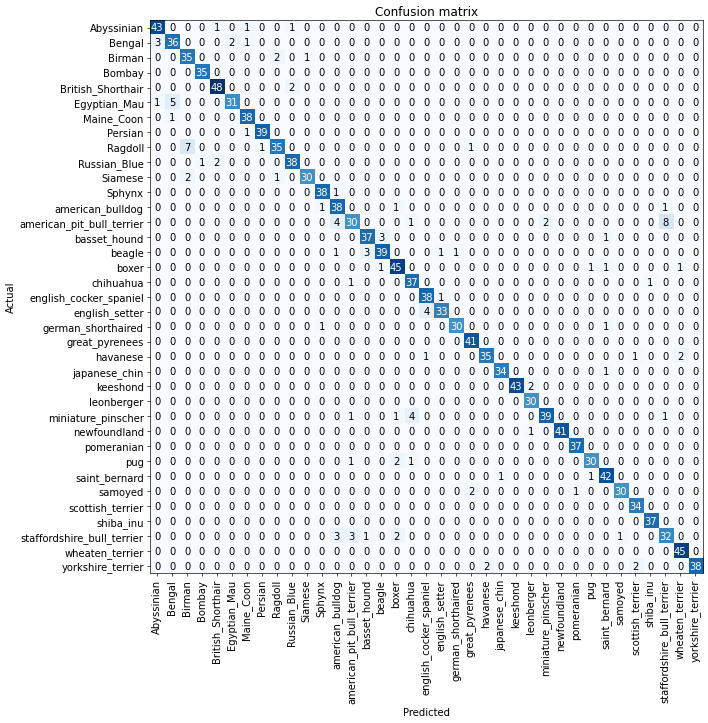

In [71]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [72]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Ragdoll', 'Birman', 7),
 ('Egyptian_Mau', 'Bengal', 5)]

__this is our baseline we can start improveing from this point.__

## Improving Our Model

### Fine Tune

__Fine tune the model with almost random arguments__

In [75]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.588707,4.300000,0.445873,00:21


epoch,train_loss,valid_loss,error_rate,time
0,3.385068,2.263443,0.510825,00:26


> Note: this is where we overshoot. Our loss just increase over second epoch is there a better way to find a learning rate?

### The Learning Rate Finder

In [76]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


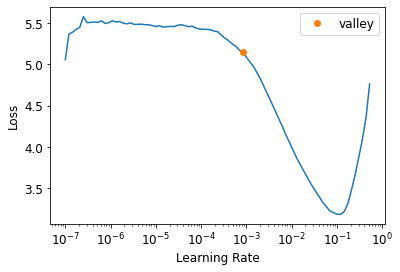

In [77]:
suggested_lr= learn.lr_find()

> Warning: There is a discrepancy between lesson and reading group notebooks. In the book we get two values from the function but in reading group, only one. I thing there was an update for this function that not reflected in the book.

In [78]:
suggested_lr

SuggestedLRs(valley=tensor(0.0008))

In [79]:
print(f"suggested: {suggested_lr.valley:.2e}")

suggested: 8.32e-04


In [80]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=8.32e-04)

epoch,train_loss,valid_loss,error_rate,time
0,2.203637,0.456601,0.139378,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.631289,0.287444,0.087280,00:26
1,0.423191,0.263927,0.085250,00:26


__At this time it decreases steadily__

#### What's under the hood of `fine_tune`

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the `fine_tune` method fastai does two things:

- Trains the randomly added layers for one epoch, with all other layers frozen
- Unfreezes all of the layers, and trains them all for the number of epochs requested

__Lets do it manually__

In [82]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 8.32e-04)

epoch,train_loss,valid_loss,error_rate,time
0,1.806578,0.363257,0.114344,00:21
1,0.697060,0.258624,0.083221,00:22
2,0.449906,0.254586,0.087957,00:21


In [83]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

find new learning rate , because now we include previous layers too.

SuggestedLRs(valley=tensor(0.0001))

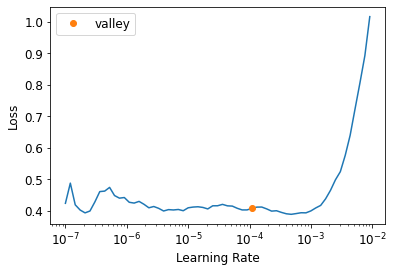

In [84]:
learn.lr_find()

Train again with the new lr.

In [85]:
learn.fit_one_cycle(6, lr_max=0.0001)

epoch,train_loss,valid_loss,error_rate,time
0,0.369805,0.265072,0.085250,00:26
1,0.379721,0.352767,0.112314,00:26
2,0.320787,0.257370,0.075778,00:26
3,0.198347,0.217450,0.066306,00:27
4,0.143628,0.217090,0.066306,00:26
5,0.111457,0.216973,0.066306,00:27


__So far so good but there is more way to go__

### Discriminative Learning Rates

__Basically we use variable learning rate for the model. Bigger rate for the later layers and smaller for early layers.__

In [86]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 8.32e-04)# first lr
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(0.00005,0.0005))#second lr with a range

epoch,train_loss,valid_loss,error_rate,time
0,1.783345,0.370482,0.119080,00:22
1,0.700986,0.293102,0.096076,00:22
2,0.448751,0.262937,0.093369,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.390943,0.245929,0.079838,00:28
1,0.356807,0.281976,0.088633,00:27
2,0.344888,0.417350,0.117727,00:27
3,0.267143,0.284152,0.081867,00:27
4,0.217775,0.330306,0.092693,00:28
5,0.172308,0.310047,0.081191,00:27
6,0.122903,0.299161,0.079161,00:27
7,0.099924,0.262270,0.074425,00:27
8,0.059424,0.278250,0.074425,00:27
9,0.045987,0.253283,0.067659,00:27


__It is better most of the times.(sometimes I do not get good results, need to arrange the `slice` values  carefully)__

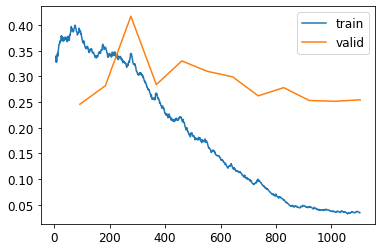

In [88]:
learn.recorder.plot_loss()

> Note: Directly from the book:

As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does not mean that it is getting less accurate, necessarily. Take a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

> Important: I need to think about it how loss increase and accuracy stil becoming better.

### Deeper Architectures

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.
However, using a deeper model is going to require more GPU RAM, so you may need to lower the size of your batches to avoid an *out-of-memory error*. This happens when you try to fit too much inside your GPU and looks like:

```
Cuda runtime error: out of memory
```

You may have to restart your notebook when this happens. The way to solve it is to use a smaller batch size, which means passing smaller groups of images at any given time through your model. You can pass the batch size you want to the call creating your `DataLoaders` with `bs=`.

The other downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is *mixed-precision training*. This refers to using less-precise numbers (*half-precision floating point*, also called *fp16*) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called *tensor cores* that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add `to_fp16()` after your `Learner` creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:

In [91]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.209030,0.308840,0.097429,00:20
1,0.562807,0.326714,0.100812,00:21
2,0.396488,0.263611,0.089310,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.255827,0.262954,0.080514,00:24
1,0.215601,0.256829,0.072395,00:24
2,0.238660,0.392900,0.099459,00:23
3,0.246021,0.409503,0.107578,00:24
4,0.196632,0.448040,0.106225,00:23
5,0.137433,0.353745,0.091340,00:23
6,0.108764,0.333932,0.085250,00:24
7,0.078872,0.295772,0.081867,00:24
8,0.055900,0.273311,0.073072,00:24
9,0.040353,0.274645,0.070365,00:24


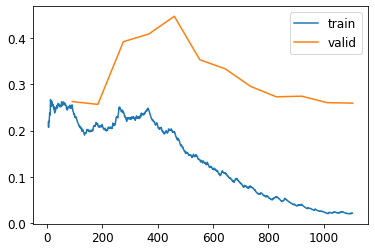

In [92]:
learn.recorder.plot_loss()

As above traing time is not changed much.